In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import scipy as sp
import pandas as pd
import rost
import os
import pymc
import shutil
import multiprocessing
import datetime

MCMC parameters

In [2]:
# # 1000 time nuno
# burn = 1e7
# iter_ = 1e8 + 1e7
# thin = 1e4

In [3]:
# # 100 time nuno
# burn = 1000000
# iter_ = 11000000
# thin = 1000

In [4]:
# # 10 times Nuno
# burn = 100000
# iter_ = 1100000
# thin = 100

In [5]:
# ##Nuno's values
# burn = 10000 
# iter_ = 110000
# thin = 10

In [6]:
# # medium fast
# burn = 1000 
# iter_ = 11000
# thin = 10

In [7]:
# # ##fast
# burn = 0
# iter_ = 10
# thin = 1

## Create test data

estimate realistic parameters

In [8]:
cell_number_data_file = '../../data/cell_number_data.csv'
# cell_number_data_file = '../../140204_create_test_data/140204_step_data/step_data.pkl'

cell_number_data = pd.read_csv(cell_number_data_file)

In [9]:
cell_number_data['GF'] = cell_number_data['PCNA'] / cell_number_data['SOX2']
cell_number_data['mi'] = cell_number_data['m'] / cell_number_data['PCNA'] * 13.2 / 50.

In [10]:
cell_number_data.head()

,ID,time,pos,SOX2,PCNA,m,GF,mi
0,0D_1,0,-1500,NaN,NaN,2,NaN,NaN
1,0D_1,0,-1450,NaN,NaN,1,NaN,NaN
2,0D_1,0,-1400,NaN,NaN,3,NaN,NaN
3,0D_1,0,-1350,33,26,1,0.787879,0.010154
4,0D_1,0,-1300,38,32,1,0.842105,0.008250


Intraexperimental 

In [11]:
intra = cell_number_data[['ID', 'time', 'SOX2', 'PCNA', 'm']].groupby('ID').agg({'time': ['mean'], 
                                                                                 'SOX2': ['mean', 'std'],
                                                                                 'PCNA': ['mean', 'std'],
                                                                                 'm': ['mean', 'std']})
time = intra['time', 'mean']
time.name = 'time'
intra = intra.drop('time', axis = 'columns')
intra['time', ''] = time
intra

SOX2                 PCNA                   m           time
           mean       std       mean       std      mean       std     
ID                                                                     
0D_1  32.714286  2.054210  29.272727  2.240130  1.354839  0.838586    0
0D_2  31.272727  2.240130  28.545455  1.967925  1.413793  1.086187    0
0D_3  30.272727  3.196589  25.454545  3.643175  2.000000  1.035098    0
3D_1  30.166667  2.249579  26.583333  3.028901  1.333333  1.287301    3
3D_2  26.523810  3.092233  23.600000  4.031455  1.086957  1.091911    3
3D_3  28.375000  1.586401  26.600000  2.131398  1.555556  1.271283    3
4D_1  29.631579  2.947891  28.315789  3.986820  3.000000  1.954017    4
4D_2  28.666667  2.575526  26.857143  3.424700  2.885714  1.728165    4
4D_3  31.523810  2.088517  29.650000  3.248886  3.342857  2.042819    4
6D_1  31.718750  2.796707  30.032258  2.994260  3.000000  1.959592    6
6D_2  32.000000  3.480558  30.600000  3.482731  3.316667  2.054278    6
6D_3  29.750000  3.626593  28.041667  3.276785  2.500000  1.611695    6
8D_1  31.277778  1.964555  30.130435  2.455131  3.474576  1.725628    8
8D_2  30.750000  1.970172  29.700000  2.105132  3.363636  1.575157    8
8D_3  31.590909  2.260617  29.619048  2.438774  2.966667  1.716981    8

SOX2

In [12]:
SOX2_mean = cell_number_data['SOX2'].mean()
SOX2_std  = cell_number_data['SOX2'].std()
SOX2_mean, SOX2_std

(30.5, 3.099092948650799)

create test data

In [13]:
parameters = dict(
    SOX2_mean = 30.0,
    SOX2_sigma = 3,
    
    GF_left_pop = 0.8,
    GF_right_pop = 0.95,
    GF_sigma_inter = 0.04,
    
    mi_left_pop = 0.015,
    mi_right_pop = 0.04,
    mi_sigma_inter = 0.01,
    
    switchpoint_pop = -500.0,
    switchpoint_sigma_inter = 0.1,
)

In [14]:
def create_test_data(parameters, Ninter):
    ls = 50.0 # length of section
    l = pd.read_csv('../../data/cell_length_data.csv')['cell_length'].mean()  # length of cell
    
    def step_function(x, switchpoint, left_value, right_value):
        ''' This function should return something in the same format as the passed array 

          Specifically, it produces an output that has an array of the same size of the experimental data
        but whose contents are the lower average until the switchpoint, and the upper average past the switchpoint.
        For all purposes, this builds the model to which we want to compare the data.
        '''
        return sp.where(x<=switchpoint, left_value, right_value)

    x = sp.arange(-2000, 400, 50)

    
    dfs = []
    for i in range(Ninter):
        df = pd.DataFrame()
        switchpoint = sp.random.normal(parameters['switchpoint_pop'], parameters['switchpoint_sigma_inter'])
        def switch(left_value, right_value, x=x, switchpoint = switchpoint):
            return step_function(x, switchpoint, left_value, right_value)

        df['SOX2'] = sp.around(sp.random.normal(parameters['SOX2_mean'], parameters['SOX2_sigma'], len(x))).astype('int')
        
        GF_left = sp.random.normal(parameters['GF_left_pop'], parameters['GF_sigma_inter'])
        GF_left = max(0, min(1, GF_left))
        GF_right = sp.random.normal(parameters['GF_right_pop'], parameters['GF_sigma_inter'])
        GF_right = max(0, min(1, GF_right))
#         IPython.embed()
        df['PCNA'] = sp.random.binomial(df['SOX2'], switch(GF_left, GF_right))
        
        mi_left = sp.random.normal(parameters['mi_left_pop'], parameters['mi_sigma_inter'])
        mi_left = max(0, min(1, mi_left))
        mi_right = sp.random.normal(parameters['mi_right_pop'], parameters['mi_sigma_inter'])
        mi_right = max(0, min(1, mi_right))
        
        df['m'] = sp.random.binomial( sp.around(df['PCNA'] * ls / l).astype('int'), switch(mi_left, mi_right)) 
        df['ID'] = i
        df['pos'] = x
        df['time'] = 0
        # randomly delete some data
        for j in range(len(x) / 2):
            ind = pd.Series(df.index).sample().iloc[0]
            df.loc[ind, 'SOX2'] = sp.nan
            df.loc[ind, 'PCNA'] = sp.nan
        
        dfs.append(df.copy())
            
    return pd.concat(dfs)

In [15]:
test_data = create_test_data(parameters, 10)

plot test data

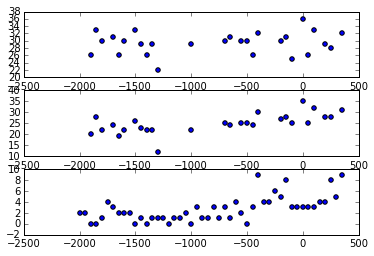

In [16]:
for ID, group in test_data.groupby('ID'):
    fig, ax = plt.subplots(3)
    ax[0].scatter(group['pos'], group['SOX2'])
    ax[1].scatter(group['pos'], group['PCNA'])
    ax[2].scatter(group['pos'], group['m'])
    plt.show()
    break

## pymc model

In [17]:
outgrowth = pd.Series([0.0, 56.5, 163.28571428571428, 451.75, 1278.5, 2257.25],
                      index = pd.Index([0.0, 2.0, 3.0, 4.0, 6.0, 8.0], name = 'time'),
                      name = 'outgrowth')
                         

def make_model(data, mi_mean_min, mi_mean_max, GF_mean_min, GF_mean_max, constant_proliferation = False):
    values_SOX2 = {}
    values_m = {}
    values_nonPCNA = {}
    switchpoint = {}
    mi_left = {}
    GF_left = {}
    SOX2_mean_left = {}
    mi_right = {}
    GF_right = {}
    SOX2_mean_right = {}
    cells_SOX2_float = {}
    cells_nonPCNA = {}
    cells_m = {}

    
    ls = 50.0 # length of section
    l = pd.read_csv('../../data/cell_length_data.csv')['cell_length'].mean()  # length of cell
    
    def step_function(x, switchpoint, left_value, right_value):
        ''' This function should return something in the same format as the passed array 

          Specifically, it produces an output that has an array of the same size of the experimental data
        but whose contents are the lower average until the switchpoint, and the upper average past the switchpoint.
        For all purposes, this builds the model to which we want to compare the data.
        '''
        return sp.where(x<=switchpoint, left_value, right_value)

    def ma(array, fill_value):
        return sp.ma.masked_array(array, sp.isnan(array), fill_value = fill_value)
  


    #data = data.dropna(how='all', subset = ['m', 'PCNA', 'SOX2'])
    
    # I'll drop all nan because of the potential bug with the binomials (see my question on stackoverflow)
    data = data.dropna(how='all', subset = ['m', 'PCNA', 'SOX2'])
    data = data.sort_values(['ID', 'pos'])
    
    # priors for global mean values
    
    # define priors for left side of step function
    mi_left_pop= pymc.Uniform('mi_left_pop', lower = mi_mean_min, upper = mi_mean_max, value = 0.02)
    GF_left_pop = pymc.Uniform('GF_left_pop', lower = GF_mean_min, upper = GF_mean_max, value = 0.8)

    # define priors for right side of step function
    if constant_proliferation:
        mi_right_pop = mi_left_pop
        GF_right_pop = GF_left_pop
    else:
        mi_right_pop = pymc.Uniform('mi_right_pop', lower = mi_mean_min, upper = mi_mean_max, value = 0.04)
        GF_right_pop = pymc.Uniform('GF_right_pop', lower = GF_mean_min, upper = GF_mean_max, value = 0.9)
        # stepsizes
        @pymc.deterministic(name='step_mi', plot=True)
        def step_mi(mi_left = mi_left_pop, mi_right = mi_right_pop):
            return mi_right - mi_left

        @pymc.deterministic(name='step_GF', plot=True)
        def step_GF(GF_left = GF_left_pop, GF_right = GF_right_pop):
            return GF_right - GF_left

    
    # prior distribution for sigma beeing uniformly distributed
    GF_sigma_inter = pymc.Uniform('GF_sigma_inter', lower = 0.001, upper = 0.2)
    mi_sigma_inter = pymc.Uniform('mi_sigma_inter', lower = 0.001, upper = 0.2)

    
    # switchpoint
    if not constant_proliferation:
        switchpoint_pop = pymc.Uniform('switchpoint_pop',
                                       lower = -2000,
                                       upper = outgrowth[data['time'].iloc[0]], 
                                       value = -500)
        switchpoint_sigma_inter = pymc.Uniform('switchpoint_sigma_inter', lower=1.0, upper=400.0, value = 50)
    
    
    for ID, IDdata in data.groupby('ID'):
        values_SOX2[ID] = ma(IDdata['SOX2'], 35.5)
        values_nonPCNA[ID] = ma(IDdata['SOX2'] - IDdata['PCNA'], 3.5)
        values_m[ID] = ma(IDdata['m'], 1.5)
        
        # Model definition

        #priors
        # switchpoint[ID]: for all observables
        
        if constant_proliferation:
            switchpoint[ID] = 0.0
        else:
            switchpoint[ID] = pymc.Normal('switchpoint_{0}'.format(ID), mu = switchpoint_pop,\
                                          tau = 1/switchpoint_sigma_inter**2, value = -500,
                                         plot = False)
            

        # number of SOX2 cells
        SOX2_mean = sp.mean(values_SOX2[ID])
        SOX2_std = sp.std(values_SOX2[ID])


        # define priors for left side of step function
        mi_left[ID] = pymc.TruncatedNormal('mi_left_{0}'.format(ID), mu = mi_left_pop, tau = 1.0 / mi_sigma_inter**2,
                                           a = 0.0, b = 1.0,
                                  value = 0.02, plot = False)
        GF_left[ID] = pymc.TruncatedNormal('GF_left_{0}'.format(ID), mu = GF_left_pop, tau = 1.0 / GF_sigma_inter**2,
                                           a = 0.0, b = 1.0,
                                  value = 0.5, plot = False)
        

        # define priors for right side of step function
        mi_right[ID] = pymc.TruncatedNormal('mi_right_{0}'.format(ID), mu = mi_right_pop, tau = 1.0 / mi_sigma_inter**2,
                                            a = 0.0, b = 1.0,
                                            value = 0.02, plot = False)
        GF_right[ID] = pymc.TruncatedNormal('GF_right_{0}'.format(ID), mu = GF_right_pop, tau = 1.0 / GF_sigma_inter**2,
                                            a = 0.0, b = 1.0,
                                            value = 0.5, plot = False)
    
        
        # step functions
        @pymc.deterministic(name='mi_{}'.format(ID))
        def mi(positions = sp.array(IDdata['pos']), switchpoint = switchpoint[ID],
               left_value = mi_left[ID], right_value = mi_right[ID]):
            return step_function(positions, switchpoint, left_value, right_value)

        @pymc.deterministic(name='GF_{}'.format(ID))
        def GF(positions = sp.array(IDdata['pos']), switchpoint = switchpoint[ID],
               left_value = GF_left[ID], right_value = GF_right[ID]):
            return step_function(positions, switchpoint, left_value, right_value)

        @pymc.deterministic(name='SOX2_mean_{}'.format(ID))
        def SOX2_mean(positions = sp.array(IDdata['pos']), switchpoint = switchpoint[ID],
                      left_value = SOX2_mean , right_value = SOX2_mean):
            return step_function(positions, switchpoint, left_value, right_value)

        #likelihoods
        cells_SOX2_float[ID] = pymc.Normal('cells_SOX2_float_{0}'.format(ID), mu=SOX2_mean, tau = 1/SOX2_std**2, value = values_SOX2[ID],\
                                           plot = False, observed = True)


        @pymc.deterministic(name='cells_SOX2_{}'.format(ID))
        def cells_SOX2(csf = cells_SOX2_float[ID]):
            return sp.around(csf)




        cells_nonPCNA[ID] = pymc.Binomial('cells_nonPCNA_{0}'.format(ID),\
                                        n = cells_SOX2,\
                                        p = (1.0 - GF),\
                                        value = values_nonPCNA[ID], observed = True, plot = False )

        @pymc.deterministic(name='cells_PCNA_{}'.format(ID))
        def cells_PCNA(cnp = cells_nonPCNA[ID], cs = cells_SOX2):
            return  cs - cnp



        @pymc.deterministic(name='cells_PCNA_section_{}'.format(ID))
        def cells_PCNA_section(cp = cells_PCNA, ls = ls, l = l):
            return cp * ls / l



        cells_m[ID] = pymc.Binomial('cells_m_{0}'.format(ID),\
                                n = cells_PCNA_section,\
                                p = mi,\
                                value = values_m[ID], observed = True, plot = False)



    
    values_SOX2 = pymc.Container(values_SOX2)
    values_SOX2 = pymc.Container(values_SOX2)
    values_m = pymc.Container(values_m)
    values_nonPCNA = pymc.Container(values_nonPCNA)
    switchpoint = pymc.Container(switchpoint)
    mi_left = pymc.Container(mi_left)
    GF_left = pymc.Container(GF_left)
    SOX2_mean_left = pymc.Container(SOX2_mean_left)
    mi_right = pymc.Container(mi_right)
    GF_right = pymc.Container(GF_right)
    SOX2_mean_right = pymc.Container(SOX2_mean_right)
    cells_SOX2_float = pymc.Container(cells_SOX2_float)
    cells_nonPCNA = pymc.Container(cells_nonPCNA)
    cells_m = pymc.Container(cells_m)

    return locals()

## Fit test data

In [18]:
GF_mean_min = (cell_number_data['PCNA'] / cell_number_data['SOX2']).min()
GF_mean_max = (cell_number_data['PCNA'] / cell_number_data['SOX2']).max()

mi_mean_min = (cell_number_data['m'] / cell_number_data['PCNA'] * 13.2 / 50.0).min()
mi_mean_max = (cell_number_data['m'] / cell_number_data['PCNA'] * 13.2 / 50.0).max()

In [19]:
# medium fast
burn = 1000 
iter_ = 11000
thin = 10

In [20]:
# # fast
# burn = 0 
# iter_ = 100
# thin = 1

In [21]:
M = pymc.MCMC(make_model(test_data, mi_mean_min, mi_mean_max, GF_mean_min, GF_mean_max, constant_proliferation = False))

In [22]:
M.sample(iter=iter_, burn=burn, thin=thin)

 [-----------------100%-----------------] 11001 of 11000 complete in 166.0 sec

In [25]:
parameters

{'GF_left_pop': 0.8,
 'GF_right_pop': 0.95,
 'GF_sigma_inter': 0.04,
 'SOX2_mean': 30.0,
 'SOX2_sigma': 3,
 'mi_left_pop': 0.015,
 'mi_right_pop': 0.04,
 'mi_sigma_inter': 0.01,
 'switchpoint_pop': -500.0,
 'switchpoint_sigma_inter': 0.1}

Plotting GF_left_pop
Plotting mi_sigma_inter
Plotting mi_right_pop
Plotting step_mi
Plotting switchpoint_pop
Plotting GF_right_pop
Plotting switchpoint_sigma_inter
Plotting step_GF
Plotting GF_sigma_inter
Plotting mi_left_pop


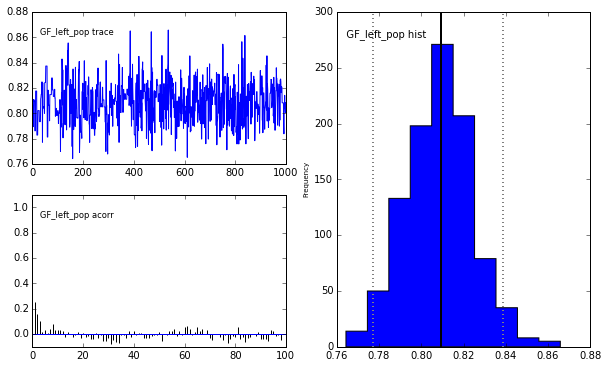

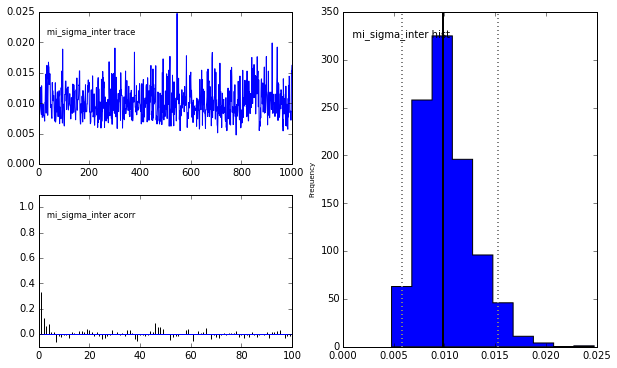

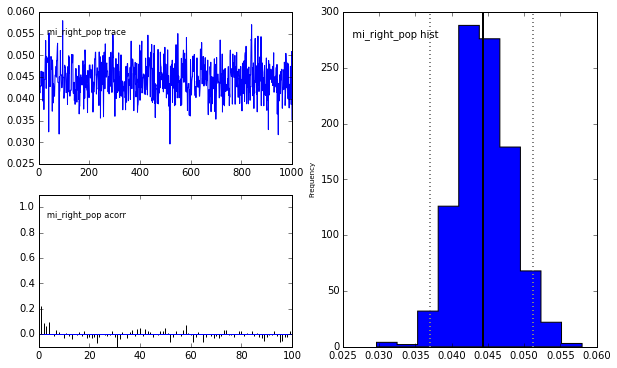

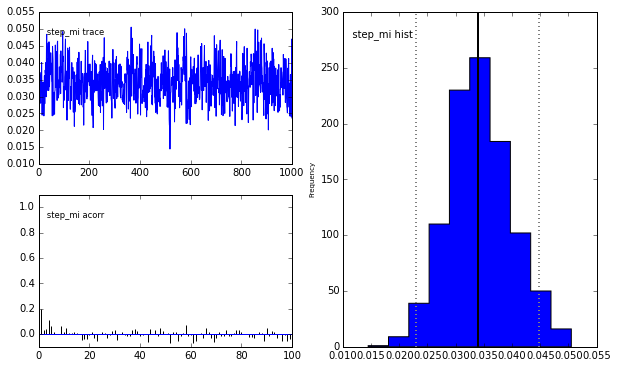

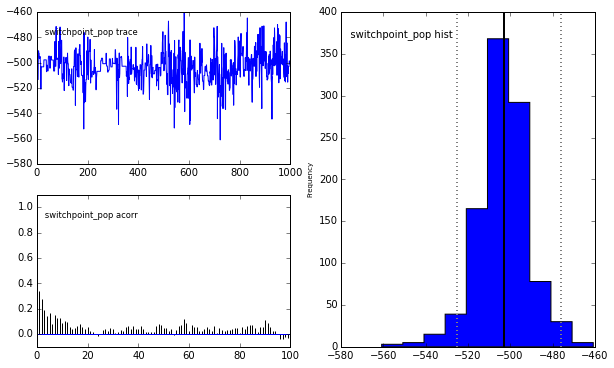

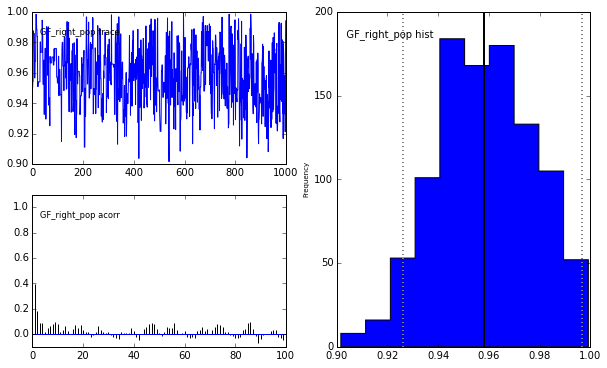

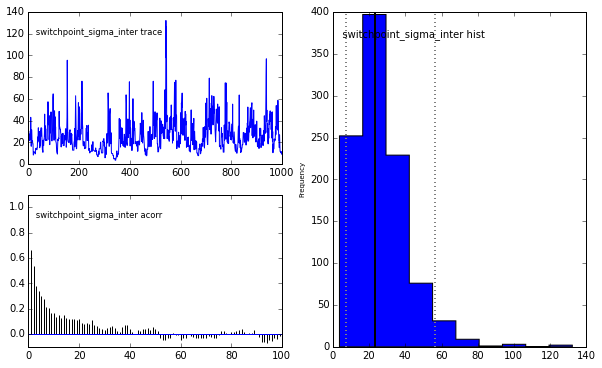

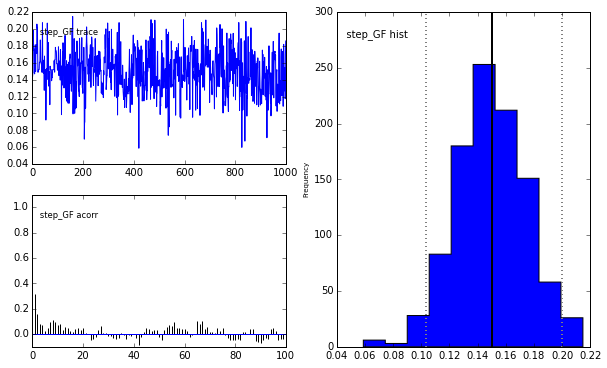

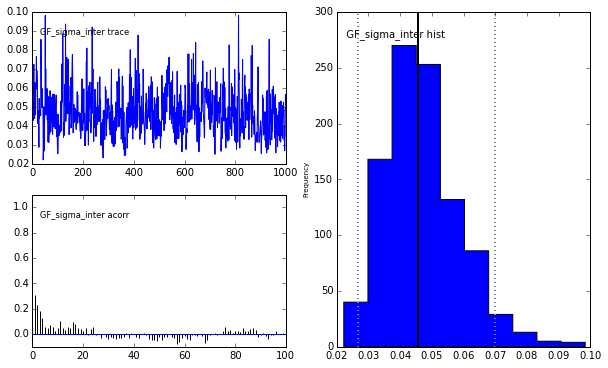

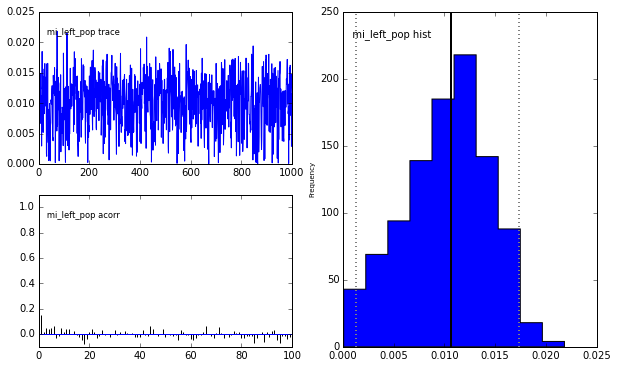

In [23]:
pymc.Matplot.plot(M)

## Fit the real data

In [29]:
GF_mean_min = (cell_number_data['PCNA'] / cell_number_data['SOX2']).min()
GF_mean_max = (cell_number_data['PCNA'] / cell_number_data['SOX2']).max()

mi_mean_min = 0.0
mi_mean_max = 0.1

In [30]:
# # fast
# burn = 0 
# iter_ = 10
# thin = 1

In [31]:
# # 10 times Nuno
# burn = 100000
# iter_ = 1100000
# thin = 100

In [39]:
# 1/10 times Nuno
burn = 1000
iter_ = 11000
thin = 1

In [40]:
# 1/50 times Nuno
burn = 200
iter_ = 2200
thin = 1

In [44]:
# 1/50 times Nuno
burn = 300
iter_ = 3300
thin = 1

In [45]:
# # 1/100 times Nuno
# burn = 100
# iter_ = 1100
# thin = 1

In [46]:
# # 1/1000 times Nuno
# burn = 10
# iter_ = 110
# thin = 1

In [47]:
%%time
dir_ = '{0}_{1}'.format(cell_number_data_file.split('.')[-2].split('/')[-1], datetime.datetime.now().strftime("%y%m%dT%H%M%S") )
out_path = os.path.join('results', dir_)

try:
    shutil.rmtree(out_path)
    print('Removed previous results')
except:
    print('No previous results to remove?!')
rost.mkdir_p(out_path)

meta = pd.Series()
meta['datafile'] = cell_number_data_file
meta['burn'] = burn
meta['iter_'] = iter_
meta['thin'] = thin
meta.to_csv(os.path.join(out_path, 'meta.txt'), sep = '\t')

cell_number_data.to_pickle(os.path.join(out_path, 'cell_number_data.pkl'))

def fit_model((ID, data)):
    print ID    

    M = pymc.MCMC(make_model(data, mi_mean_min, mi_mean_max, GF_mean_min, GF_mean_max), db='hdf5', dbname = os.path.join(out_path, '{0}.hdf5'.format(ID)))
    M.sample(iter=iter_, burn=burn, thin=thin, progress_bar=False)
    print()
    pymc.Matplot.plot(M, path = out_path, suffix = '_{0}'.format(ID));
    plt.close('all')
    M.db.close()


l = [[ID, data] for ID, data in cell_number_data.groupby('time')]

p = multiprocessing.Pool(processes=3)

p.map(fit_model, l);

No previous results to remove?!
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 42.1 s
4
0
3
()()()


Plotting GF_right_pop
Plotting switchpoint_sigma_inter
Plotting mi_sigma_inter
PlottingPlottingPlotting mi_right_pop
 GF_right_pop
 GF_right_pop
PlottingPlottingPlotting step_GF
 GF_sigma_inter
 mi_right_pop
PlottingPlottingPlotting GF_sigma_inter
 switchpoint_pop
 step_mi
PlottingPlottingPlotting switchpoint_pop
 GF_left_pop
 switchpoint_pop
PlottingPlottingPlotting switchpoint_sigma_inter
 mi_sigma_inter
 GF_left_pop
PlottingPlottingPlotting step_mi
 step_GF
 step_GF
PlottingPlottingPlotting mi_sigma_inter
 mi_left_pop
 switchpoint_sigma_inter
PlottingPlottingPlotting GF_left_pop
 step_mi
 GF_sigma_inter
PlottingPlottingPlotting mi_left_pop
 mi_right_pop
 mi_left_pop
86

()()

Plotting step_mi
Plotting switchpoint_pop
PlottingPlotting mi_left_pop
 switchpoint_sigma_inter
PlottingPlotting GF_left_pop
 step_mi
PlottingPlotting switchpoint_sigma_inter
 step_GF
PlottingPlotting G